In [74]:
import numpy as np
import nnfs
import os
import cv2
nnfs.init()

# Dense layer
class Layer_Dense:
    # Layer initialization
    def __init__(self, n_inputs, n_neurons,weight_regularizer_l1=0,
                 weight_regularizer_l2=0,bias_regularizer_l1=0,bias_regularizer_l2=0):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        #Add lambda regularization hyperparameters
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2
        
    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases
    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        #Gradients on regularization
        #L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1=np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1*dL1
        #L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2*self.weight_regularizer_l2*self.weights
        #L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1=np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1*dL1
        #L2 on bias
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2*self.bias_regularizer_l2*self.biases
  
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

#Dropout
class Layer_Dropout:
    def __init__(self,rate):
        self.rate = 1-rate #dropout rate
    #Forward pass
    def forward(self, inputs, training):
        self.inputs = inputs
        #if not in training mode return values
        if not training:
            self.output = inputs.copy()
            return
        
        #generate scaled mask
        self.binary_mask=np.random.binomial(1,self.rate,size=inputs.shape)/self.rate
        #apply mask
        self.output = inputs * self.binary_mask
        
    #Backward pass
    def backward(self,dvalues):
        #Gradient
        self.dinputs = dvalues*self.binary_mask

class Layer_Input:
    #Forward pass
    def forward(self,inputs, training):
        self.output = inputs
        
# ReLU activation
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)
    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0
    #calculate predictions for outputs
    def predictions(self,outputs):
        return outputs
    
# Softmax activation
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
    # Backward pass
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)
        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output 
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,single_dvalues)
    #calculate predictions for outputs
    def predictions(self,outputs):
        return np.argmax(outputs,axis=1)

#Sigmoid activation
class Activation_Sigmoid:
    def forward(self,inputs, training):
        #Save input calculate/save output
        self.inputs = inputs
        self.output = 1 / (1+np.exp(-inputs))
    
    def backward(self,dvalues):
        self.dinputs=dvalues*(1-self.output)*self.output
    def predictions(self,outputs):
        return(outputs>0.5)*1

class Activation_Linear:
    #forward pass
    def forward(self,inputs, training):
        #Just remember values
        self.inputs = inputs
        self.output = inputs
        
    #Backward pass
    def backward(self,dvalues):
        #derivative is 1,1 *dvalues = dvalues
        self.dinputs = dvalues.copy()
        
    def predictions(self,outputs):
        return outputs


#Learning rate set to 1 
class Optimizer_SGD:
    #Initialize optimizer - set settings,
    #learning rate of 1. is default for this optimizer
    def __init__(self,learning_rate=1.0,decay=0.,momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
        
    #Call before parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate*(1./(1.+self.decay * self.iterations))
        
    #Update parameters
    def update_params(self,layer):
        
        #if we use momentum:
        if self.momentum:
            #If layer doesn't have momentum arrays, init in zero
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                #if no momentum for weights neither for biases
                #we need to create it 
                layer.bias_momentums = np.zeros_like(layer.biases)
                
            #Update weights and biases with momentums
            weight_updates = self.momentum * layer.weight_momentums-self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
        
        #Updates without momentum
        else: 
            weight_updates = - self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
        
        #Update weights and biases
        layer.weights += weight_updates
        layer.biases += bias_updates
        
        
    #Call after any parameter updates 
    def post_update_params(self):
        self.iterations += 1
    

class Optimizer_Adagrad:
    #Initialize optimizer - set settings,
    #learning rate of 1. is default for this optimizer
    def __init__(self,learning_rate=1.0,decay=0.,epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        
    #Call before parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate*(1./(1.+self.decay * self.iterations))
        
    #Update parameters
    def update_params(self,layer):
     
        #If layer doesn't have cache for Adagrad, initialize
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
                
        #Update cache with squared current gradients
        layer.weight_cache += layer.dweights ** 2
        layer.bias_cache += layer.dbiases ** 2
        
        #Update weights and biases
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache)+self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache)+self.epsilon)
        
            
        
    #Call after any parameter updates 
    def post_update_params(self):
        self.iterations += 1    


class Optimizer_RMSprop:
    #Initialize optimizer - set settings,
    #learning rate of 1. is default for this optimizer
    def __init__(self,learning_rate=0.001,decay=0.,epsilon=1e-7,rho = 0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
        
    #Call before parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate*(1./(1.+self.decay * self.iterations))
        
    #Update parameters
    def update_params(self,layer):
     
        #If layer doesn't have cache for Adagrad, initialize
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
                
        #Update cache with squared current gradients
        layer.weight_cache = self.rho*layer.weight_cache +(1-self.rho)*layer.dweights ** 2
        layer.bias_cache = self.rho* layer.bias_cache+(1-self.rho)*layer.dbiases ** 2
        
        #Update weights and biases
        
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache)+self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache)+self.epsilon)
        
            
        
    #Call after any parameter updates 
    def post_update_params(self):
        self.iterations += 1

    
    
    
#Optimizer Adam
class Optimizer_Adam:
    #Initialize optimizer - set settings,
    #learning rate of 1. is default for this optimizer
    def __init__(self,learning_rate=0.001,decay=0.,epsilon=1e-7,beta_1 = 0.9,beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
    #Call before parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate*(1./(1.+self.decay * self.iterations))
        
    #Update parameters
    def update_params(self,layer):
     
        #If layer doesn't have cache for Adagrad, initialize
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums=np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
                
        #Update momentum with current gradients 
        layer.weight_momentums = self.beta_1*layer.weight_momentums+(1-self.beta_1)*layer.dweights
        layer.bias_momentums = self.beta_1*layer.bias_momentums+(1-self.beta_1)*layer.dbiases
        
        
        #Get corrected momentum first self.iteration = 0, and we need 1
        weight_momentums_corrected = layer.weight_momentums / (1-self.beta_1**(self.iterations+1))
        bias_momentums_corrected = layer.bias_momentums / (1-self.beta_1**(self.iterations+1))
        
        #Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1-self.beta_2)*layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1-self.beta_2)*layer.dbiases**2
        
        #Corrected caches
        weight_cache_corrected = layer.weight_cache / (1-self.beta_2**(self.iterations+1))
        bias_cache_corrected = layer.bias_cache / (1-self.beta_2**(self.iterations+1))
        
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected)+self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected)+self.epsilon)
        
        
            
        
    #Call after any parameter updates 
    def post_update_params(self):
        self.iterations += 1

    
# Common loss class
class Loss:
    #Regularization loss calculation
    def regularization_loss(self):
        
        #0 by default
        regularization_loss = 0
        
        for layer in self.trainable_layers:
            #L1 regularization weights, calculate only when factor > 0
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
            #L2 regularization weights
            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights*layer.weights)
            #L1 regularization biases
            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
            #L2 regularization weights
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases*layer.biases)
        return regularization_loss
    
    #Set/remember trainable layers
    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers
    
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y, *, include_regularization=False):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        #Add accumulated sum of losses and sample count
        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)
        #if just data loss return it
        if not include_regularization:
            return data_loss
        # Return loss
        return data_loss, self.regularization_loss()
    
    #Calculate accumulated loss
    def calculate_accumulated(self, *,include_regularization=False):
        #Calculate mean loss
        data_loss = self.accumulated_sum / self.accumulated_count
        #if just data loss return it
        if not include_regularization:
            return data_loss
        #Return the data and regularization losses 
        return data_loss, self.regularization_loss()
    
    #Reset variables for accumulated loss for a new epoch
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = len(y_pred)
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples),y_true]
            #Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true,axis=1)
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
        
        # Backward pass
        def backward(self, dvalues, y_true):
            # Number of samples
            samples = len(dvalues)
            # Number of labels in every sample
            # We'll use the first sample to count them
            labels = len(dvalues[0])
            # If labels are sparse, turn them into one-hot vector
            if len(y_true.shape) == 1:
                y_true = np.eye(labels)[y_true]
            # Calculate gradient
            self.dinputs = -y_true / dvalues
            # Normalize gradient
            self.dinputs = self.dinputs / samples

In [75]:
# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():
    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

        
#Binary cross-entropy loss
class Loss_BinaryCrossentropy(Loss):
    #Forward pass
    def forward(self,y_pred,y_true):
        #clip data to prevent division by 0
        #clip both sides to not drag mean towards any value
        y_pred_clipped=np.clip(y_pred,1e-7,1-1e-7)
        #calculate sample-wise loss
        sample_losses = -(y_true*np.log(y_pred_clipped)+(1-y_true)*np.log(1-y_pred_clipped))
        sample_losses = np.mean(sample_losses,axis=-1)
        #Return losses
        return sample_losses
    #Backward pass
    
    def backward(self,dvalues,y_true):
        #Number of samples
        samples = len(dvalues)    
        #Number of outputs in every samples, use first sample to count
        outputs=len(dvalues[0])
        clipped_dvalues=np.clip(dvalues,1e-7,1-1e-7)
        #Caluclate gradient
        self.dinputs=-(y_true/clipped_dvalues-(1-y_true)/(1-clipped_dvalues)) / outputs
        #Normalize gradient
        self.dinputs = self.dinputs / samples
        
class Loss_MeanSquaredError(Loss):
    #forward pass
    def forward(self,y_pred,y_true):
        
        #Calculate loss
        sample_losses = np.mean((y_true-y_pred)**2,axis=-1)
        #Return losses
        return sample_losses
    
    #Backward pass
    def backward (self,dvalues,y_true):
        #number of samples
        samples = len(dvalues)
        #number of outputs in every sample
        outputs = len(dvalues[0])
        
        #gradient on values
        self.dinputs = -2 *(y_true-dvalues)/outputs
        #Normalize gradient
        self.dinputs = self.dinputs / samples
        
class Loss_MeanAbsoluteError(Loss):
    def forward(self,y_pred,y_true):
        #Calculate loss
        sample_losses = np.mean(np.abs(y_true-y_pred),axis=-1)
        return sample_losses
    
    #Backward pass
    def backward(self,dvalues,y_true):
        #Number of samples
        samples = len(dvalues)
        #number of outputs per sample
        outputs = len(dvalues[0])
        
        #Calculate gradient
        self.dinputs = np.sign(y_true - dvalues) / outputs
        #Normalize gradients
        self.dinputs = self.dinputs / samples

class Accuracy:
    #calculate accuracy given prediction and ground truth
    def calculate(self,predictions, y):
        #get comparison
        comparisons = self.compare(predictions,y)
        #Calculate an accuracy
        accuracy = np.mean(comparisons)
        #Add accumulated sum of losses and sample count
        self.accumulated_sum += np.sum(comparisons)
        self.accumulated_count += len(comparisons)
        
        #Return accuuracy
        return accuracy
    
    #Calculate accumulated loss
    def calculate_accumulated(self):
        #Calculate mean loss
        accuracy = self.accumulated_sum / self.accumulated_count
        return accuracy
    
    #Reset variables for accumulated loss for a new epoch
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0
    

    
# Accuracy calculation for classification model
class Accuracy_Categorical(Accuracy):
    # No initialization is needed
    def init(self, y):
        pass
    # Compares predictions to the ground truth values
    def compare(self, predictions, y):
        if len(y.shape) == 2:
            y = np.argmax(y, axis=1)
        return predictions == y
    
    
class Accuracy_Regression(Accuracy):
    def __init__(self):
        #Create precision property
        self.precision = None
        
    #Calculate precision value based on ground truth
    def init(self, y, reinit=False):
        if self.precision is None or reinit:
            self.precision = np.std(y)/250
    
    #Compare predictions to the ground truth
    def compare(self, predictions, y):
        return np.absolute(predictions - y) < self.precision
    

    

# Create a Model Object

In [86]:
#Model class
class Model:
    def __init__(self):
        ##array for storing the accuracy and loss during training
        self.acc_training=np.array([])
        self.loss_training=np.array([])
        #Create a list of network objects
        self.layers = []
        # Softmax classifier's output object
        self.softmax_classifier_output = None
        
    #Add objects to the models
    def add(self,layer):
        self.layers.append(layer)
        
    def set(self,*,loss,optimizer, accuracy):
        self.loss = loss
        self.optimizer = optimizer
        self.accuracy = accuracy
        
    #Finalize the model
    def finalize(self):
        #Create and set the input layer
        self.input_layer = Layer_Input()
        #Count all objects
        layer_count = len(self.layers)
        #Initialize a list containing trainable layers
        self.trainable_layers = []
        
        #Iterate the objects
        for i in range(layer_count):
            #if it's the first layer, the previous is the input layer
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i+1]
            #all except first and last
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.layers[i+1]
            else:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]
            #Check if the layer has attribute weights and biases
            if hasattr(self.layers[i],'weights'):
                self.trainable_layers.append(self.layers[i])
        #udpate loss object with trainable layers
            self.loss.remember_trainable_layers(self.trainable_layers)
        #if output activation is softmax and loss function is categorical cross entropy
        #Create an object of combined activation and loss function containing faster gradient calculation
        #Check last layer activation function
        if isinstance(self.layers[-1], Activation_Softmax) and isinstance(self.loss, Loss_CategoricalCrossentropy):
            #Create object of combined activation and loss functions
            self.softmax_classifier_output = Activation_Softmax_Loss_CategoricalCrossentropy()
        
    
    def train(self, X, y, *, epochs=1, batch_size=None, print_every=1,validation_data=None):
        
        #Initialize accuracy object
        self.accuracy.init(y)        
        # Default value if batch size is not being set
        train_steps = 1
        
        #if there is validation data passed, set the number of steps for the validation data
        if validation_data is not None:
            validation_steps = 1
            
            #For better readability
            X_val, y_val = validation_data
        
        #calculate the number of steps according to batch size
        if batch_size is not None:
            train_steps = len(X) // batch_size
            #add 1 as the rounding is down
            if train_steps*batch_size < len(X):
                train_steps += 1
            
            if validation_data is not None:
                validation_steps = len(X_val)//batch_size
                if validation_steps*batch_size < len(X_val):
                    validation_steps += 1
        
        #Main training loop
        for epoch in range(1,epochs+1):
            print(f'epoch: {epoch}')
            #reset values of accuracy and loss
            self.loss.new_pass()
            self.accuracy.new_pass()
            #Iterate over steps
            for step in range(train_steps):
                #if no batch size then pass all data
                if batch_size is None:
                    batch_X = X
                    batch_y = y
                else:
                    batch_X = X[step*batch_size:(step+1)*batch_size]
                    batch_y = y[step*batch_size:(step+1)*batch_size]
            
                #Forward pass
                output = self.forward(batch_X, training=True)
                #Calculate loss
                data_loss, regularization_loss = self.loss.calculate(output,batch_y,include_regularization=True)
                loss = data_loss + regularization_loss
                #Get predictions and calculate an accuracy
                predictions = self.output_layer_activation.predictions(output)
                accuracy = self.accuracy.calculate(predictions,batch_y)
                #Bakcward pass
                self.backward(output,batch_y)
                #Optimize (update parameters)
                self.optimizer.pre_update_params()
                for layer in self.trainable_layers:
                    self.optimizer.update_params(layer)
                self.optimizer.post_update_params()
                #Print a summary
                if not step % print_every or step == train_steps - 1:
                    print(f'step: {step}, ' +
                        f'acc: {accuracy:.3f}, ' +
                        f'loss: {loss:.3f} (' +
                        f'data_loss: {data_loss:.3f}, ' +
                        f'reg_loss: {regularization_loss:.3f}), ' +
                        f'lr: {self.optimizer.current_learning_rate}')
                    self.acc_training=np.append(self.acc_training,accuracy)
                    self.loss_training=np.append(self.loss_training,loss)
            
            #get and print each epoch loss and accuracy
            epoch_data_loss, epoch_regularization_loss = self.loss.calculate_accumulated(include_regularization=True)
            epoch_loss = epoch_data_loss + epoch_regularization_loss
            epoch_accuracy = self.accuracy.calculate_accumulated()
            print(f'training, ' +
                    f'acc: {epoch_accuracy:.3f}, ' +
                    f'loss: {epoch_loss:.3f} (' +
                    f'data_loss: {epoch_data_loss:.3f}, ' +
                    f'reg_loss: {epoch_regularization_loss:.3f}), ' +
                    f'lr: {self.optimizer.current_learning_rate}')
       
            if validation_data is not None:
                #reset accumulated value in loss and accuracy
                self.loss.new_pass()
                self.accuracy.new_pass()
                #iterate over steps
                for step in range(validation_steps):
                    if batch_size is None:
                        batch_X = X_val
                        batch_y = y_val
                    else:
                        batch_X = X_val[step*batch_size:(step+1)*batch_size]
                        batch_y = y_val[step*batch_size:(step+1)*batch_size]

                    #Forward pass
                    output = self.forward(batch_X, training=False)
                    #Calculate the loss
                    self.loss.calculate(output, batch_y)
                    #Get predictions and calculate an accuracy
                    predictions = self.output_layer_activation.predictions(output)
                    self.accuracy.calculate(predictions, batch_y)
                # Get and print validation loss and accuracy
                validation_loss = self.loss.calculate_accumulated()
                validation_accuracy = self.accuracy.calculate_accumulated()
                #print a summary
                print(f'validation, '+
                        f'acc: {validation_accuracy:.3f}, '+
                        f'loss: {validation_loss:.3f}')
                
    def forward(self, X, training):
        #Call forward method on the input layer
        self.input_layer.forward(X, training)
        #Call forward method of every object in a chain
        #pass output of the previous object as a parameter
        for layer in self.layers:
            layer.forward(layer.prev.output, training)
        #layer is now the last object from the list, return its output
        return layer.output
         
    def backward(self, output ,y):
        
        #check if the combined softmax and loss is set and use it
        #if softmax classifier
        if self.softmax_classifier_output is not None:
            #call backward method on the combined activation and loss
            self.softmax_classifier_output.backward(output, y)
            #we are not using last backward on last layer as we are using vvombined object
            self.layers[-1].dinputs = self.softmax_classifier_output.dinputs
            #Call backward method in reversed order passing dinputs as a parameter
            for layer in reversed(self.layers[:-1]):
                layer.backward(layer.next.dinputs)
            return
        #Call backward method on the loss
        self.loss.backward(output, y)
        
        #Call backward method going through all the objects in reversed order
        for layer in reversed(self.layers):
            layer.backward(layer.next.dinputs)
        


 
            

# Load the data from the mnist dataset


In [80]:
def load_mnist_dataset(dataset, path):
    #list of labels
    labels = os.listdir(os.path.join(path,dataset))
    #Create lists of data
    X = []
    y = []

    #iterate in each folder
    for label in labels:
        for file in os.listdir(os.path.join(path,dataset,label)):
            #read the image
            image =cv2.imread(os.path.join(path,dataset,label,file), cv2.IMREAD_UNCHANGED)
            X.append(image)
            y.append(label)
    return np.array(X),np.array(y).astype('uint8')

#now to load train and dataset
def create_data_mnist(path):
    X, y = load_mnist_dataset('train',path)
    X_test, y_test = load_mnist_dataset('test',path)
    return X, y, X_test, y_test
    

# Full routine
## Check twice the validation part

In [81]:
X, y, X_test, y_test = create_data_mnist('fashion_mnist_images')
#shuffle data
keys = np.array(range(X.shape[0]))
np.random.shuffle(keys)
X = X[keys]
y = y[keys]
#reshape in one long vector of 28x28 input and scale to range -1 to 1
X = (X.reshape(X.shape[0],-1).astype(np.float32)-127.5)/127.5
X_test = (X_test.reshape(X_test.shape[0],-1).astype(np.float32)-127.5)/127.5




In [215]:
#decay_list=[.5, .1, 1e-4,1e-5] #rms prop
#decay_list =[.5, .1, 1e-4,1e-5] #adamgrad
decay_list =[.5, .1, .01, .001] #sgd
acc_ada = np.empty((len(decay_list),240))
loss_ada = np.empty((len(decay_list),240))



for i,dec in enumerate(decay_list):
    #Instantiate the model
    model = Model()

    #Add layers
    model.add(Layer_Dense(X.shape[1],128))
    model.add(Activation_ReLU())
    model.add(Layer_Dense(128,128))
    model.add(Activation_ReLU())
    model.add(Layer_Dense(128,10))
    model.add(Activation_Softmax())
    print(f'\n***** DECAY: {dec} *****')
    model.set(loss=Loss_CategoricalCrossentropy(),optimizer=Optimizer_Adam(decay=dec),accuracy=Accuracy_Categorical())

    model.finalize()
    model.train(X, y,validation_data=(X_test, y_test), epochs=5, batch_size=128, print_every=10)
    acc_ada[i]=model.acc_training
    loss_ada[i]=model.loss_training


***** DECAY: 0.5 *****
epoch: 1
step: 0, acc: 0.109, loss: 2.303 (data_loss: 2.303, reg_loss: 0.000), lr: 0.001
step: 10, acc: 0.211, loss: 2.262 (data_loss: 2.262, reg_loss: 0.000), lr: 0.00016666666666666666
step: 20, acc: 0.242, loss: 2.222 (data_loss: 2.222, reg_loss: 0.000), lr: 9.090909090909092e-05
step: 30, acc: 0.234, loss: 2.174 (data_loss: 2.174, reg_loss: 0.000), lr: 6.25e-05
step: 40, acc: 0.344, loss: 2.138 (data_loss: 2.138, reg_loss: 0.000), lr: 4.761904761904762e-05
step: 50, acc: 0.359, loss: 2.102 (data_loss: 2.102, reg_loss: 0.000), lr: 3.846153846153846e-05
step: 60, acc: 0.273, loss: 2.088 (data_loss: 2.088, reg_loss: 0.000), lr: 3.2258064516129034e-05
step: 70, acc: 0.234, loss: 2.091 (data_loss: 2.091, reg_loss: 0.000), lr: 2.7777777777777776e-05
step: 80, acc: 0.352, loss: 2.012 (data_loss: 2.012, reg_loss: 0.000), lr: 2.4390243902439026e-05
step: 90, acc: 0.273, loss: 2.018 (data_loss: 2.018, reg_loss: 0.000), lr: 2.173913043478261e-05
step: 100, acc: 0.203, 

step: 350, acc: 0.438, loss: 1.628 (data_loss: 1.628, reg_loss: 0.000), lr: 2.43605359317905e-06
step: 360, acc: 0.453, loss: 1.556 (data_loss: 1.556, reg_loss: 0.000), lr: 2.406738868832732e-06
step: 370, acc: 0.570, loss: 1.559 (data_loss: 1.559, reg_loss: 0.000), lr: 2.3781212841854933e-06
step: 380, acc: 0.586, loss: 1.563 (data_loss: 1.563, reg_loss: 0.000), lr: 2.3501762632197415e-06
step: 390, acc: 0.438, loss: 1.624 (data_loss: 1.624, reg_loss: 0.000), lr: 2.3228803716608596e-06
step: 400, acc: 0.516, loss: 1.563 (data_loss: 1.563, reg_loss: 0.000), lr: 2.2962112514351322e-06
step: 410, acc: 0.531, loss: 1.570 (data_loss: 1.570, reg_loss: 0.000), lr: 2.2701475595913733e-06
step: 420, acc: 0.492, loss: 1.595 (data_loss: 1.595, reg_loss: 0.000), lr: 2.2446689113355782e-06
step: 430, acc: 0.422, loss: 1.646 (data_loss: 1.646, reg_loss: 0.000), lr: 2.2197558268590455e-06
step: 440, acc: 0.523, loss: 1.625 (data_loss: 1.625, reg_loss: 0.000), lr: 2.195389681668496e-06
step: 450, acc

step: 200, acc: 0.492, loss: 1.507 (data_loss: 1.507, reg_loss: 0.000), lr: 1.243008079552517e-06
step: 210, acc: 0.516, loss: 1.439 (data_loss: 1.439, reg_loss: 0.000), lr: 1.2353304508956147e-06
step: 220, acc: 0.547, loss: 1.462 (data_loss: 1.462, reg_loss: 0.000), lr: 1.2277470841006752e-06
step: 230, acc: 0.477, loss: 1.562 (data_loss: 1.562, reg_loss: 0.000), lr: 1.2202562538133007e-06
step: 240, acc: 0.516, loss: 1.482 (data_loss: 1.482, reg_loss: 0.000), lr: 1.2128562765312312e-06
step: 250, acc: 0.555, loss: 1.473 (data_loss: 1.473, reg_loss: 0.000), lr: 1.2055455093429778e-06
step: 260, acc: 0.484, loss: 1.525 (data_loss: 1.525, reg_loss: 0.000), lr: 1.1983223487118035e-06
step: 270, acc: 0.539, loss: 1.486 (data_loss: 1.486, reg_loss: 0.000), lr: 1.1911852293031567e-06
step: 280, acc: 0.484, loss: 1.522 (data_loss: 1.522, reg_loss: 0.000), lr: 1.1841326228537596e-06
step: 290, acc: 0.500, loss: 1.530 (data_loss: 1.530, reg_loss: 0.000), lr: 1.1771630370806356e-06
step: 300, 

step: 80, acc: 0.578, loss: 1.216 (data_loss: 1.216, reg_loss: 0.000), lr: 0.0001111111111111111
step: 90, acc: 0.594, loss: 1.179 (data_loss: 1.179, reg_loss: 0.000), lr: 0.0001
step: 100, acc: 0.578, loss: 1.209 (data_loss: 1.209, reg_loss: 0.000), lr: 9.090909090909092e-05
step: 110, acc: 0.500, loss: 1.287 (data_loss: 1.287, reg_loss: 0.000), lr: 8.333333333333333e-05
step: 120, acc: 0.625, loss: 1.040 (data_loss: 1.040, reg_loss: 0.000), lr: 7.692307692307693e-05
step: 130, acc: 0.625, loss: 1.051 (data_loss: 1.051, reg_loss: 0.000), lr: 7.142857142857142e-05
step: 140, acc: 0.648, loss: 0.993 (data_loss: 0.993, reg_loss: 0.000), lr: 6.666666666666667e-05
step: 150, acc: 0.594, loss: 1.066 (data_loss: 1.066, reg_loss: 0.000), lr: 6.25e-05
step: 160, acc: 0.617, loss: 1.071 (data_loss: 1.071, reg_loss: 0.000), lr: 5.882352941176471e-05
step: 170, acc: 0.664, loss: 0.962 (data_loss: 0.962, reg_loss: 0.000), lr: 5.555555555555555e-05
step: 180, acc: 0.633, loss: 1.065 (data_loss: 1.0

step: 450, acc: 0.734, loss: 0.768 (data_loss: 0.768, reg_loss: 0.000), lr: 1.0764262648008611e-05
step: 460, acc: 0.734, loss: 0.790 (data_loss: 0.790, reg_loss: 0.000), lr: 1.0649627263045793e-05
step: 468, acc: 0.740, loss: 0.741 (data_loss: 0.741, reg_loss: 0.000), lr: 1.0559662090813095e-05
training, acc: 0.714, loss: 0.820 (data_loss: 0.820, reg_loss: 0.000), lr: 1.0559662090813095e-05
validation, acc: 0.719, loss: 0.807
epoch: 3
step: 0, acc: 0.727, loss: 0.863 (data_loss: 0.863, reg_loss: 0.000), lr: 1.0548523206751054e-05
step: 10, acc: 0.680, loss: 0.803 (data_loss: 0.803, reg_loss: 0.000), lr: 1.0438413361169101e-05
step: 20, acc: 0.648, loss: 0.950 (data_loss: 0.950, reg_loss: 0.000), lr: 1.0330578512396693e-05
step: 30, acc: 0.664, loss: 0.954 (data_loss: 0.954, reg_loss: 0.000), lr: 1.0224948875255623e-05
step: 40, acc: 0.734, loss: 0.804 (data_loss: 0.804, reg_loss: 0.000), lr: 1.012145748987854e-05
step: 50, acc: 0.727, loss: 0.734 (data_loss: 0.734, reg_loss: 0.000), l

step: 300, acc: 0.734, loss: 0.716 (data_loss: 0.716, reg_loss: 0.000), lr: 5.824111822947e-06
step: 310, acc: 0.680, loss: 0.833 (data_loss: 0.833, reg_loss: 0.000), lr: 5.790387955993051e-06
step: 320, acc: 0.773, loss: 0.689 (data_loss: 0.689, reg_loss: 0.000), lr: 5.7570523891767405e-06
step: 330, acc: 0.734, loss: 0.941 (data_loss: 0.941, reg_loss: 0.000), lr: 5.724098454493417e-06
step: 340, acc: 0.711, loss: 0.792 (data_loss: 0.792, reg_loss: 0.000), lr: 5.6915196357427435e-06
step: 350, acc: 0.680, loss: 0.774 (data_loss: 0.774, reg_loss: 0.000), lr: 5.659309564233163e-06
step: 360, acc: 0.688, loss: 0.769 (data_loss: 0.769, reg_loss: 0.000), lr: 5.627462014631401e-06
step: 370, acc: 0.719, loss: 0.715 (data_loss: 0.715, reg_loss: 0.000), lr: 5.595970900951315e-06
step: 380, acc: 0.734, loss: 0.688 (data_loss: 0.688, reg_loss: 0.000), lr: 5.564830272676683e-06
step: 390, acc: 0.789, loss: 0.620 (data_loss: 0.620, reg_loss: 0.000), lr: 5.534034311012728e-06
step: 400, acc: 0.758

step: 170, acc: 0.758, loss: 0.585 (data_loss: 0.585, reg_loss: 0.000), lr: 0.0009832841691248771
step: 180, acc: 0.844, loss: 0.519 (data_loss: 0.519, reg_loss: 0.000), lr: 0.0009823182711198428
step: 190, acc: 0.773, loss: 0.592 (data_loss: 0.592, reg_loss: 0.000), lr: 0.0009813542688910698
step: 200, acc: 0.719, loss: 0.673 (data_loss: 0.673, reg_loss: 0.000), lr: 0.000980392156862745
step: 210, acc: 0.789, loss: 0.440 (data_loss: 0.440, reg_loss: 0.000), lr: 0.0009794319294809011
step: 220, acc: 0.852, loss: 0.420 (data_loss: 0.420, reg_loss: 0.000), lr: 0.0009784735812133072
step: 230, acc: 0.750, loss: 0.701 (data_loss: 0.701, reg_loss: 0.000), lr: 0.0009775171065493648
step: 240, acc: 0.789, loss: 0.550 (data_loss: 0.550, reg_loss: 0.000), lr: 0.0009765625
step: 250, acc: 0.875, loss: 0.412 (data_loss: 0.412, reg_loss: 0.000), lr: 0.0009756097560975611
step: 260, acc: 0.820, loss: 0.452 (data_loss: 0.452, reg_loss: 0.000), lr: 0.0009746588693957114
step: 270, acc: 0.883, loss: 0

step: 30, acc: 0.852, loss: 0.407 (data_loss: 0.407, reg_loss: 0.000), lr: 0.0009117432530999271
step: 40, acc: 0.852, loss: 0.437 (data_loss: 0.437, reg_loss: 0.000), lr: 0.0009109127345600292
step: 50, acc: 0.859, loss: 0.380 (data_loss: 0.380, reg_loss: 0.000), lr: 0.0009100837277029487
step: 60, acc: 0.828, loss: 0.404 (data_loss: 0.404, reg_loss: 0.000), lr: 0.0009092562284051646
step: 70, acc: 0.820, loss: 0.493 (data_loss: 0.493, reg_loss: 0.000), lr: 0.0009084302325581395
step: 80, acc: 0.828, loss: 0.497 (data_loss: 0.497, reg_loss: 0.000), lr: 0.000907605736068252
step: 90, acc: 0.844, loss: 0.458 (data_loss: 0.458, reg_loss: 0.000), lr: 0.0009067827348567284
step: 100, acc: 0.875, loss: 0.379 (data_loss: 0.379, reg_loss: 0.000), lr: 0.0009059612248595759
step: 110, acc: 0.820, loss: 0.443 (data_loss: 0.443, reg_loss: 0.000), lr: 0.0009051412020275163
step: 120, acc: 0.906, loss: 0.257 (data_loss: 0.257, reg_loss: 0.000), lr: 0.000904322662325918
step: 130, acc: 0.828, loss: 

step: 380, acc: 0.859, loss: 0.393 (data_loss: 0.393, reg_loss: 0.000), lr: 0.0008483922965979468
step: 390, acc: 0.906, loss: 0.295 (data_loss: 0.295, reg_loss: 0.000), lr: 0.000847673137238281
step: 400, acc: 0.859, loss: 0.386 (data_loss: 0.386, reg_loss: 0.000), lr: 0.0008469551960701278
step: 410, acc: 0.867, loss: 0.414 (data_loss: 0.414, reg_loss: 0.000), lr: 0.0008462384700008463
step: 420, acc: 0.875, loss: 0.462 (data_loss: 0.462, reg_loss: 0.000), lr: 0.0008455229559482539
step: 430, acc: 0.828, loss: 0.454 (data_loss: 0.454, reg_loss: 0.000), lr: 0.0008448086508405847
step: 440, acc: 0.852, loss: 0.441 (data_loss: 0.441, reg_loss: 0.000), lr: 0.000844095551616443
step: 450, acc: 0.820, loss: 0.381 (data_loss: 0.381, reg_loss: 0.000), lr: 0.0008433836552247618
step: 460, acc: 0.922, loss: 0.241 (data_loss: 0.241, reg_loss: 0.000), lr: 0.0008426729586247576
step: 468, acc: 0.875, loss: 0.338 (data_loss: 0.338, reg_loss: 0.000), lr: 0.0008421052631578947
training, acc: 0.875, 

step: 240, acc: 0.781, loss: 0.546 (data_loss: 0.546, reg_loss: 0.000), lr: 0.0009976057462090984
step: 250, acc: 0.875, loss: 0.410 (data_loss: 0.410, reg_loss: 0.000), lr: 0.0009975062344139652
step: 260, acc: 0.844, loss: 0.439 (data_loss: 0.439, reg_loss: 0.000), lr: 0.0009974067424695793
step: 270, acc: 0.867, loss: 0.401 (data_loss: 0.401, reg_loss: 0.000), lr: 0.0009973072703700011
step: 280, acc: 0.852, loss: 0.437 (data_loss: 0.437, reg_loss: 0.000), lr: 0.000997207818109294
step: 290, acc: 0.836, loss: 0.468 (data_loss: 0.468, reg_loss: 0.000), lr: 0.0009971083856815236
step: 300, acc: 0.852, loss: 0.436 (data_loss: 0.436, reg_loss: 0.000), lr: 0.0009970089730807579
step: 310, acc: 0.844, loss: 0.434 (data_loss: 0.434, reg_loss: 0.000), lr: 0.0009969095803010666
step: 320, acc: 0.836, loss: 0.456 (data_loss: 0.456, reg_loss: 0.000), lr: 0.000996810207336523
step: 330, acc: 0.797, loss: 0.619 (data_loss: 0.619, reg_loss: 0.000), lr: 0.000996710854181202
step: 340, acc: 0.859, 

step: 120, acc: 0.898, loss: 0.260 (data_loss: 0.260, reg_loss: 0.000), lr: 0.0009895307645114686
step: 130, acc: 0.820, loss: 0.435 (data_loss: 0.435, reg_loss: 0.000), lr: 0.000989432857086318
step: 140, acc: 0.891, loss: 0.368 (data_loss: 0.368, reg_loss: 0.000), lr: 0.0009893349690338156
step: 150, acc: 0.883, loss: 0.299 (data_loss: 0.299, reg_loss: 0.000), lr: 0.0009892371003482115
step: 160, acc: 0.805, loss: 0.532 (data_loss: 0.532, reg_loss: 0.000), lr: 0.000989139251023759
step: 170, acc: 0.852, loss: 0.354 (data_loss: 0.354, reg_loss: 0.000), lr: 0.0009890414210547138
step: 180, acc: 0.883, loss: 0.321 (data_loss: 0.321, reg_loss: 0.000), lr: 0.000988943610435333
step: 190, acc: 0.875, loss: 0.344 (data_loss: 0.344, reg_loss: 0.000), lr: 0.0009888458191598768
step: 200, acc: 0.820, loss: 0.443 (data_loss: 0.443, reg_loss: 0.000), lr: 0.0009887480472226067
step: 210, acc: 0.875, loss: 0.303 (data_loss: 0.303, reg_loss: 0.000), lr: 0.0009886502946177878
step: 220, acc: 0.867, 

step: 468, acc: 0.865, loss: 0.366 (data_loss: 0.366, reg_loss: 0.000), lr: 0.00098159509202454
training, acc: 0.873, loss: 0.346 (data_loss: 0.346, reg_loss: 0.000), lr: 0.00098159509202454
validation, acc: 0.857, loss: 0.389
epoch: 5
step: 0, acc: 0.852, loss: 0.409 (data_loss: 0.409, reg_loss: 0.000), lr: 0.0009815854568298716
step: 10, acc: 0.875, loss: 0.334 (data_loss: 0.334, reg_loss: 0.000), lr: 0.0009814891152857114
step: 20, acc: 0.836, loss: 0.399 (data_loss: 0.399, reg_loss: 0.000), lr: 0.0009813927926513308
step: 30, acc: 0.859, loss: 0.319 (data_loss: 0.319, reg_loss: 0.000), lr: 0.0009812964889211627
step: 40, acc: 0.852, loss: 0.384 (data_loss: 0.384, reg_loss: 0.000), lr: 0.0009812002040896423
step: 50, acc: 0.867, loss: 0.319 (data_loss: 0.319, reg_loss: 0.000), lr: 0.0009811039381512076
step: 60, acc: 0.883, loss: 0.292 (data_loss: 0.292, reg_loss: 0.000), lr: 0.0009810076911002982
step: 70, acc: 0.859, loss: 0.404 (data_loss: 0.404, reg_loss: 0.000), lr: 0.000980911

# Create the model object

In [194]:
import matplotlib.pyplot as plt
#acc_adam_dec1e3=model.acc_training
#loss_adam_dec1e3=model.loss_training
my_path='C:/Users/ds675/Documents/WUT/2nd/AI/Conference-LaTeX-template_10-17-19/figures'

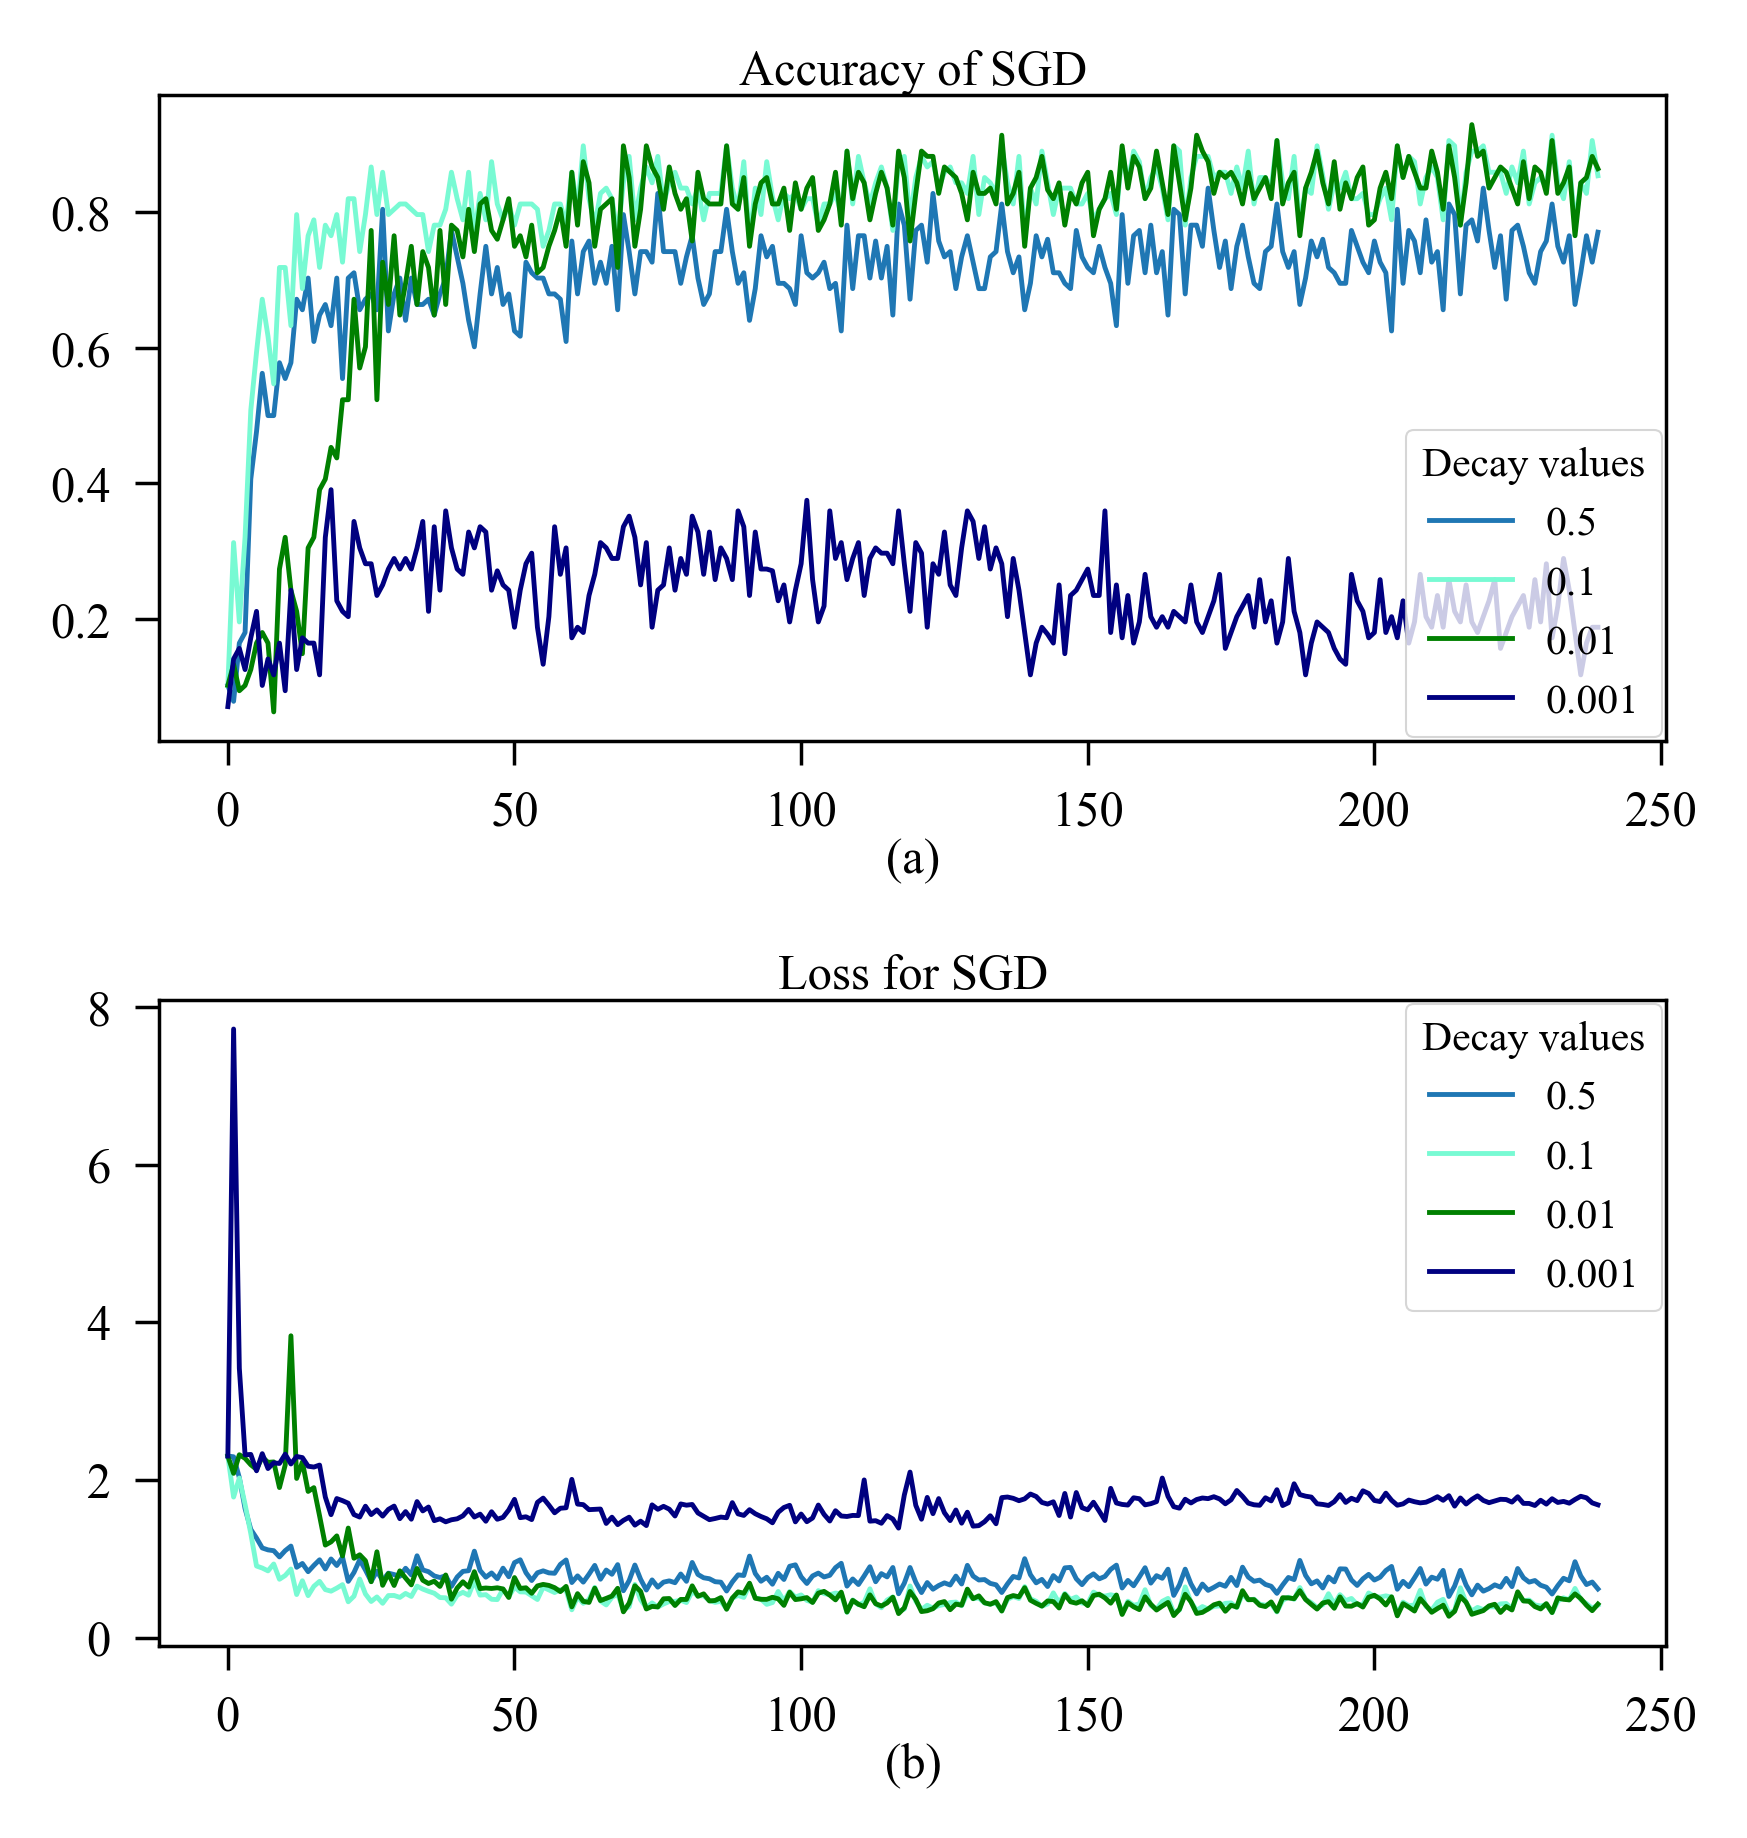

In [221]:
mm=1/25.4
decay_list =[.5, .1, .01, .001] #sgd
import matplotlib as mpl
mpl.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(2,1,figsize = (88*mm , 88*mm),
                           gridspec_kw = {'wspace':0.5,'hspace':0.4},dpi=500)
fig.subplots_adjust(left=.1, bottom=.08, right=0.97, top=0.975)
ax[0].plot(acc_sgd[0],label=f'{decay_list[0]}',lw=0.7)
ax[0].plot(acc_sgd[1],'#78FAD3',label=f'{decay_list[1]}',lw=0.7,)
ax[0].plot(acc_sgd[2],'g',label=f'{decay_list[2]}',lw=0.7,)
ax[0].plot(acc_sgd[3],'navy',label=f'{decay_list[3]}',lw=0.7,)
ax[0].set_title('Accuracy of SGD',fontsize=7,pad=-0.25)
ax[0].legend(fontsize=6, title='Decay values',title_fontsize=6,ncol=1,loc='lower right',borderaxespad=0.1).get_frame().set_linewidth(0.3)
ax[0].set_xlabel('(a)',fontsize=7,labelpad=0.25)


ax[0].tick_params(axis='both', which='major',width=0.5, labelsize=7)
for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(0.5)


ax[1].plot(loss_sgd[0],lw=0.7,label=f'{decay_list[0]}')
ax[1].plot(loss_sgd[1],'#78FAD3',lw=0.7,label=f'{decay_list[1]}')
ax[1].plot(loss_sgd[2],'g',lw=0.7,label=f'{decay_list[2]}')
ax[1].plot(loss_sgd[3],'navy',lw=0.7,label=f'{decay_list[3]}')
ax[1].set_title('Loss for SGD',fontsize=7,pad=-0.25)
ax[1].set_xlabel('(b)',fontsize=7,labelpad=0.25)
ax[1].tick_params(axis='both', which='major',width=0.5, labelsize=7)
ax[1].legend(fontsize=6, title='Decay values',title_fontsize=6,ncol=1,loc='upper right',borderaxespad=0.1).get_frame().set_linewidth(0.3)
for axis in ['top','bottom','left','right']:
    ax[1].spines[axis].set_linewidth(0.5)
    
fig.savefig(my_path+'/SGD.pdf',dpi=400)

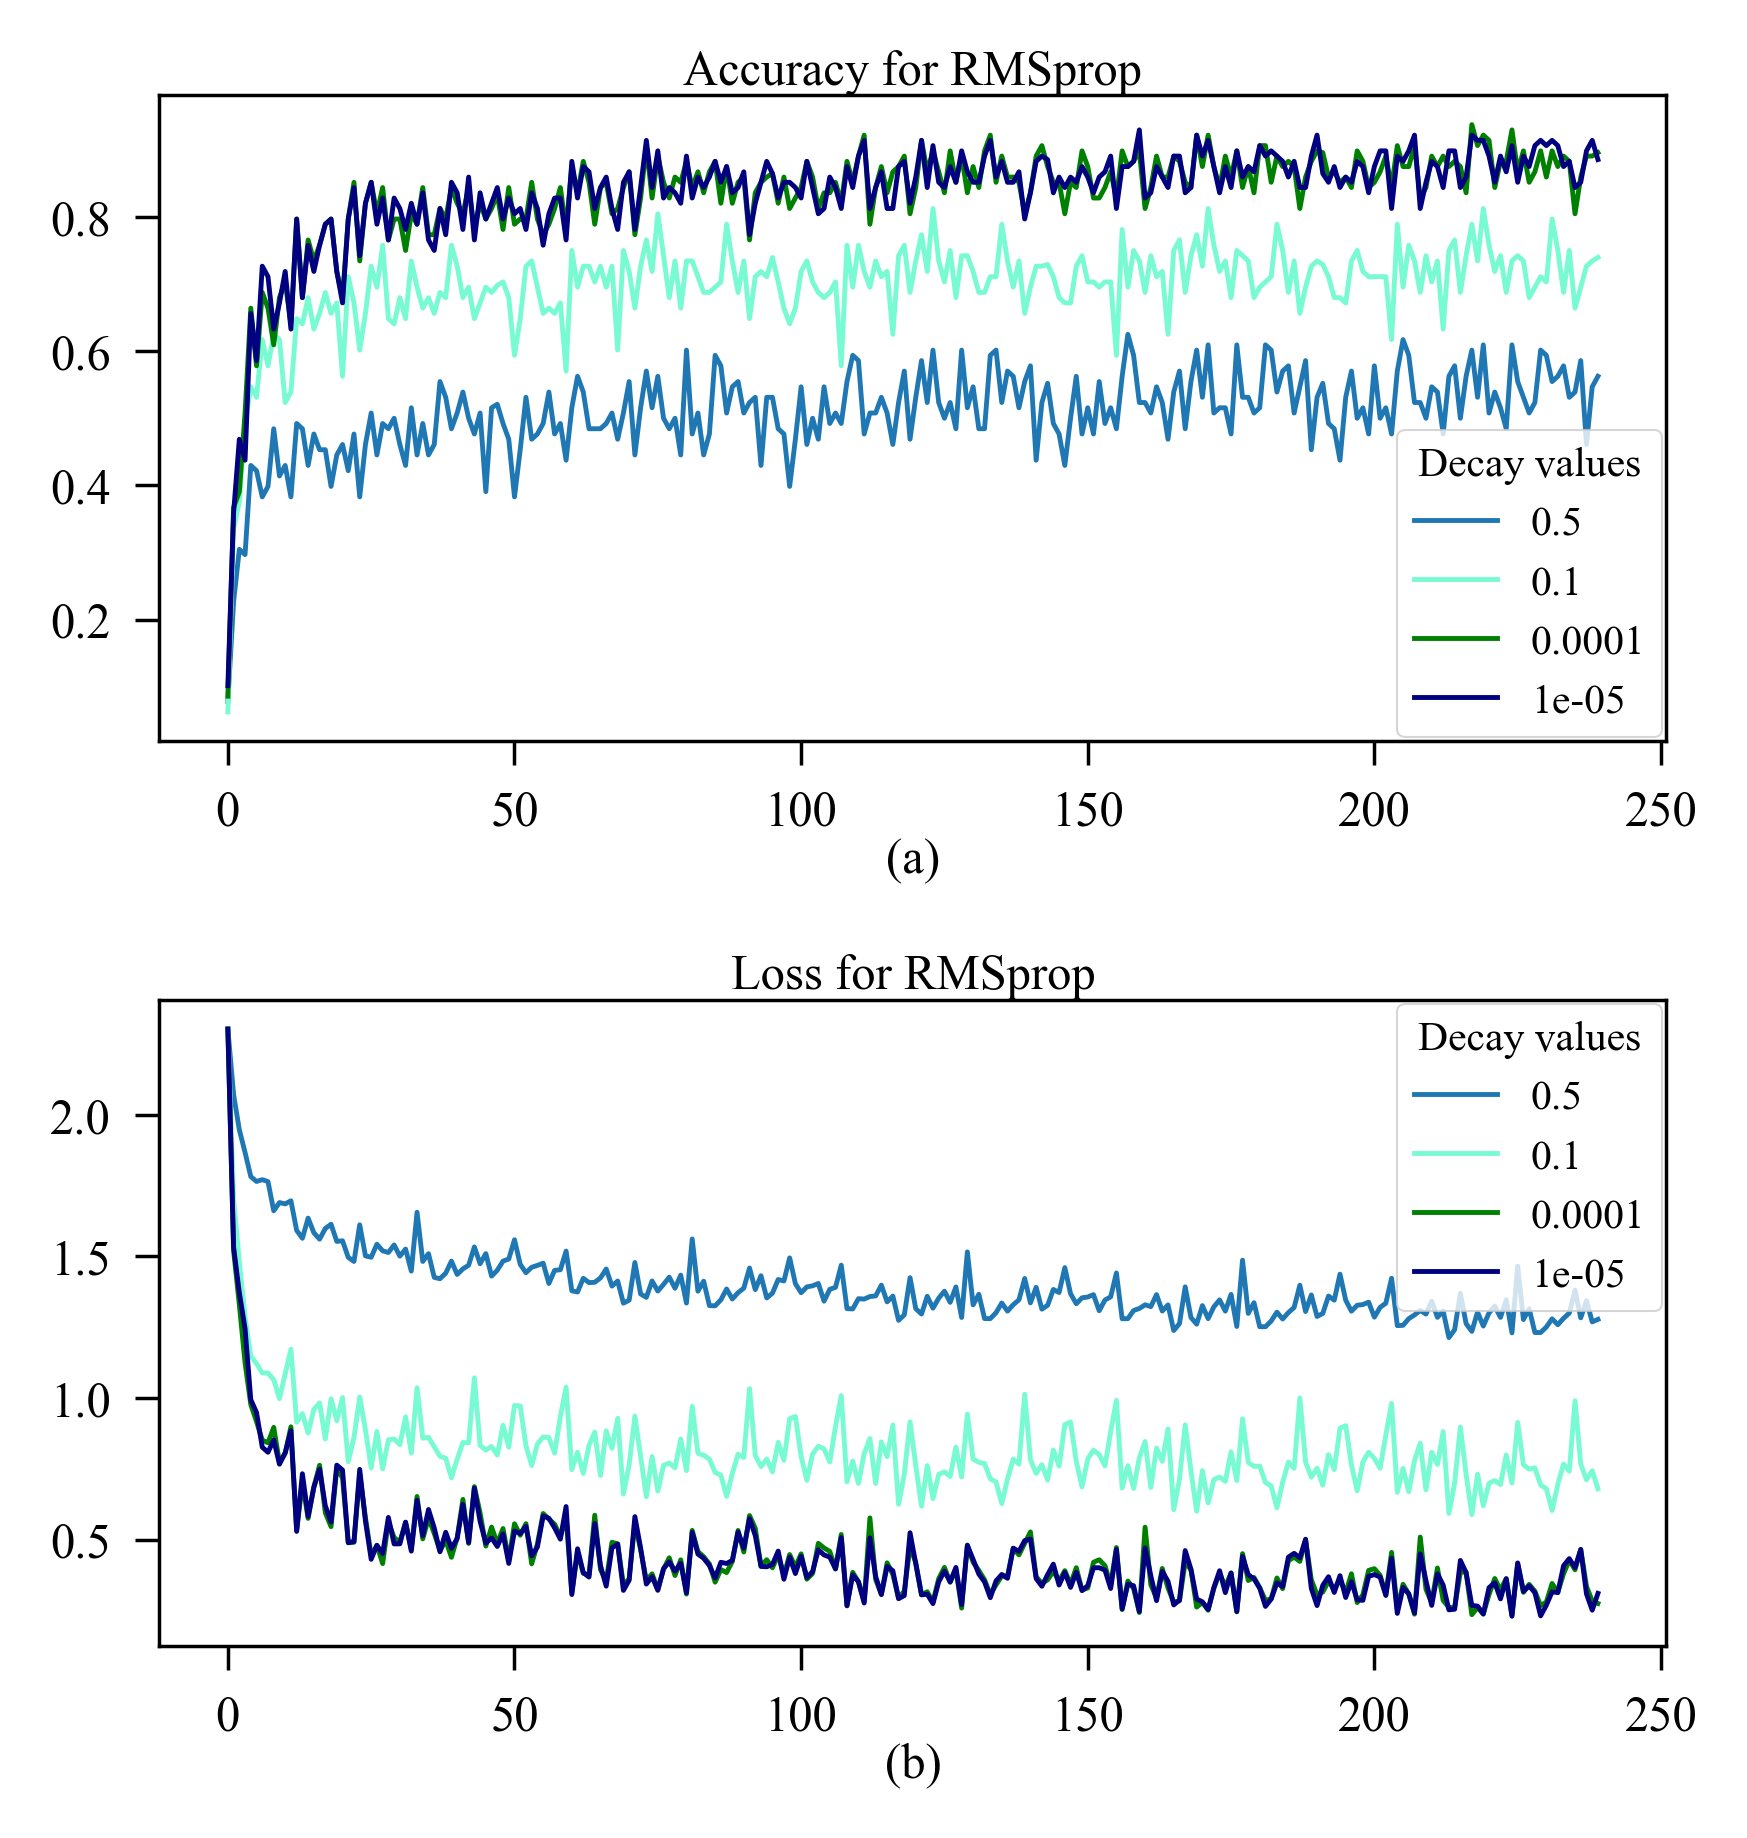

In [222]:
decay_list =[.5, .1, 1e-4,1e-5]
fig, ax = plt.subplots(2,1,figsize = (88*mm , 88*mm),
                           gridspec_kw = {'wspace':0.5,'hspace':0.4},dpi=500)
fig.subplots_adjust(left=.1, bottom=.08, right=0.97, top=0.975)
ax[0].plot(acc_rms[0],label=f'{decay_list[0]}',lw=0.7)
ax[0].plot(acc_rms[1],'#78FAD3',label=f'{decay_list[1]}',lw=0.7,)
ax[0].plot(acc_rms[2],'g',label=f'{decay_list[2]}',lw=0.7,)
ax[0].plot(acc_rms[3],'navy',label=f'{decay_list[3]}',lw=0.7,)
ax[0].set_title('Accuracy for RMSprop',fontsize=7,pad=-0.25)
ax[0].legend(fontsize=6, title='Decay values',title_fontsize=6,ncol=1,loc='lower right',borderaxespad=0.1).get_frame().set_linewidth(0.3)
ax[0].set_xlabel('(a)',fontsize=7,labelpad=0.25)


ax[0].tick_params(axis='both', which='major',width=0.5, labelsize=7)
for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(0.5)


ax[1].plot(loss_rms[0],lw=0.7,label=f'{decay_list[0]}')
ax[1].plot(loss_rms[1],'#78FAD3',lw=0.7,label=f'{decay_list[1]}')
ax[1].plot(loss_rms[2],'g',lw=0.7,label=f'{decay_list[2]}')
ax[1].plot(loss_rms[3],'navy',lw=0.7,label=f'{decay_list[3]}')
ax[1].set_title('Loss for RMSprop',fontsize=7,pad=-0.25)
ax[1].set_xlabel('(b)',fontsize=7,labelpad=0.25)
ax[1].tick_params(axis='both', which='major',width=0.5, labelsize=7)
ax[1].legend(fontsize=6, title='Decay values',title_fontsize=6,ncol=1,loc='upper right',borderaxespad=0.1).get_frame().set_linewidth(0.3)
for axis in ['top','bottom','left','right']:
    ax[1].spines[axis].set_linewidth(0.5)
    
fig.savefig(my_path+'/RMSprop.pdf',dpi=400)

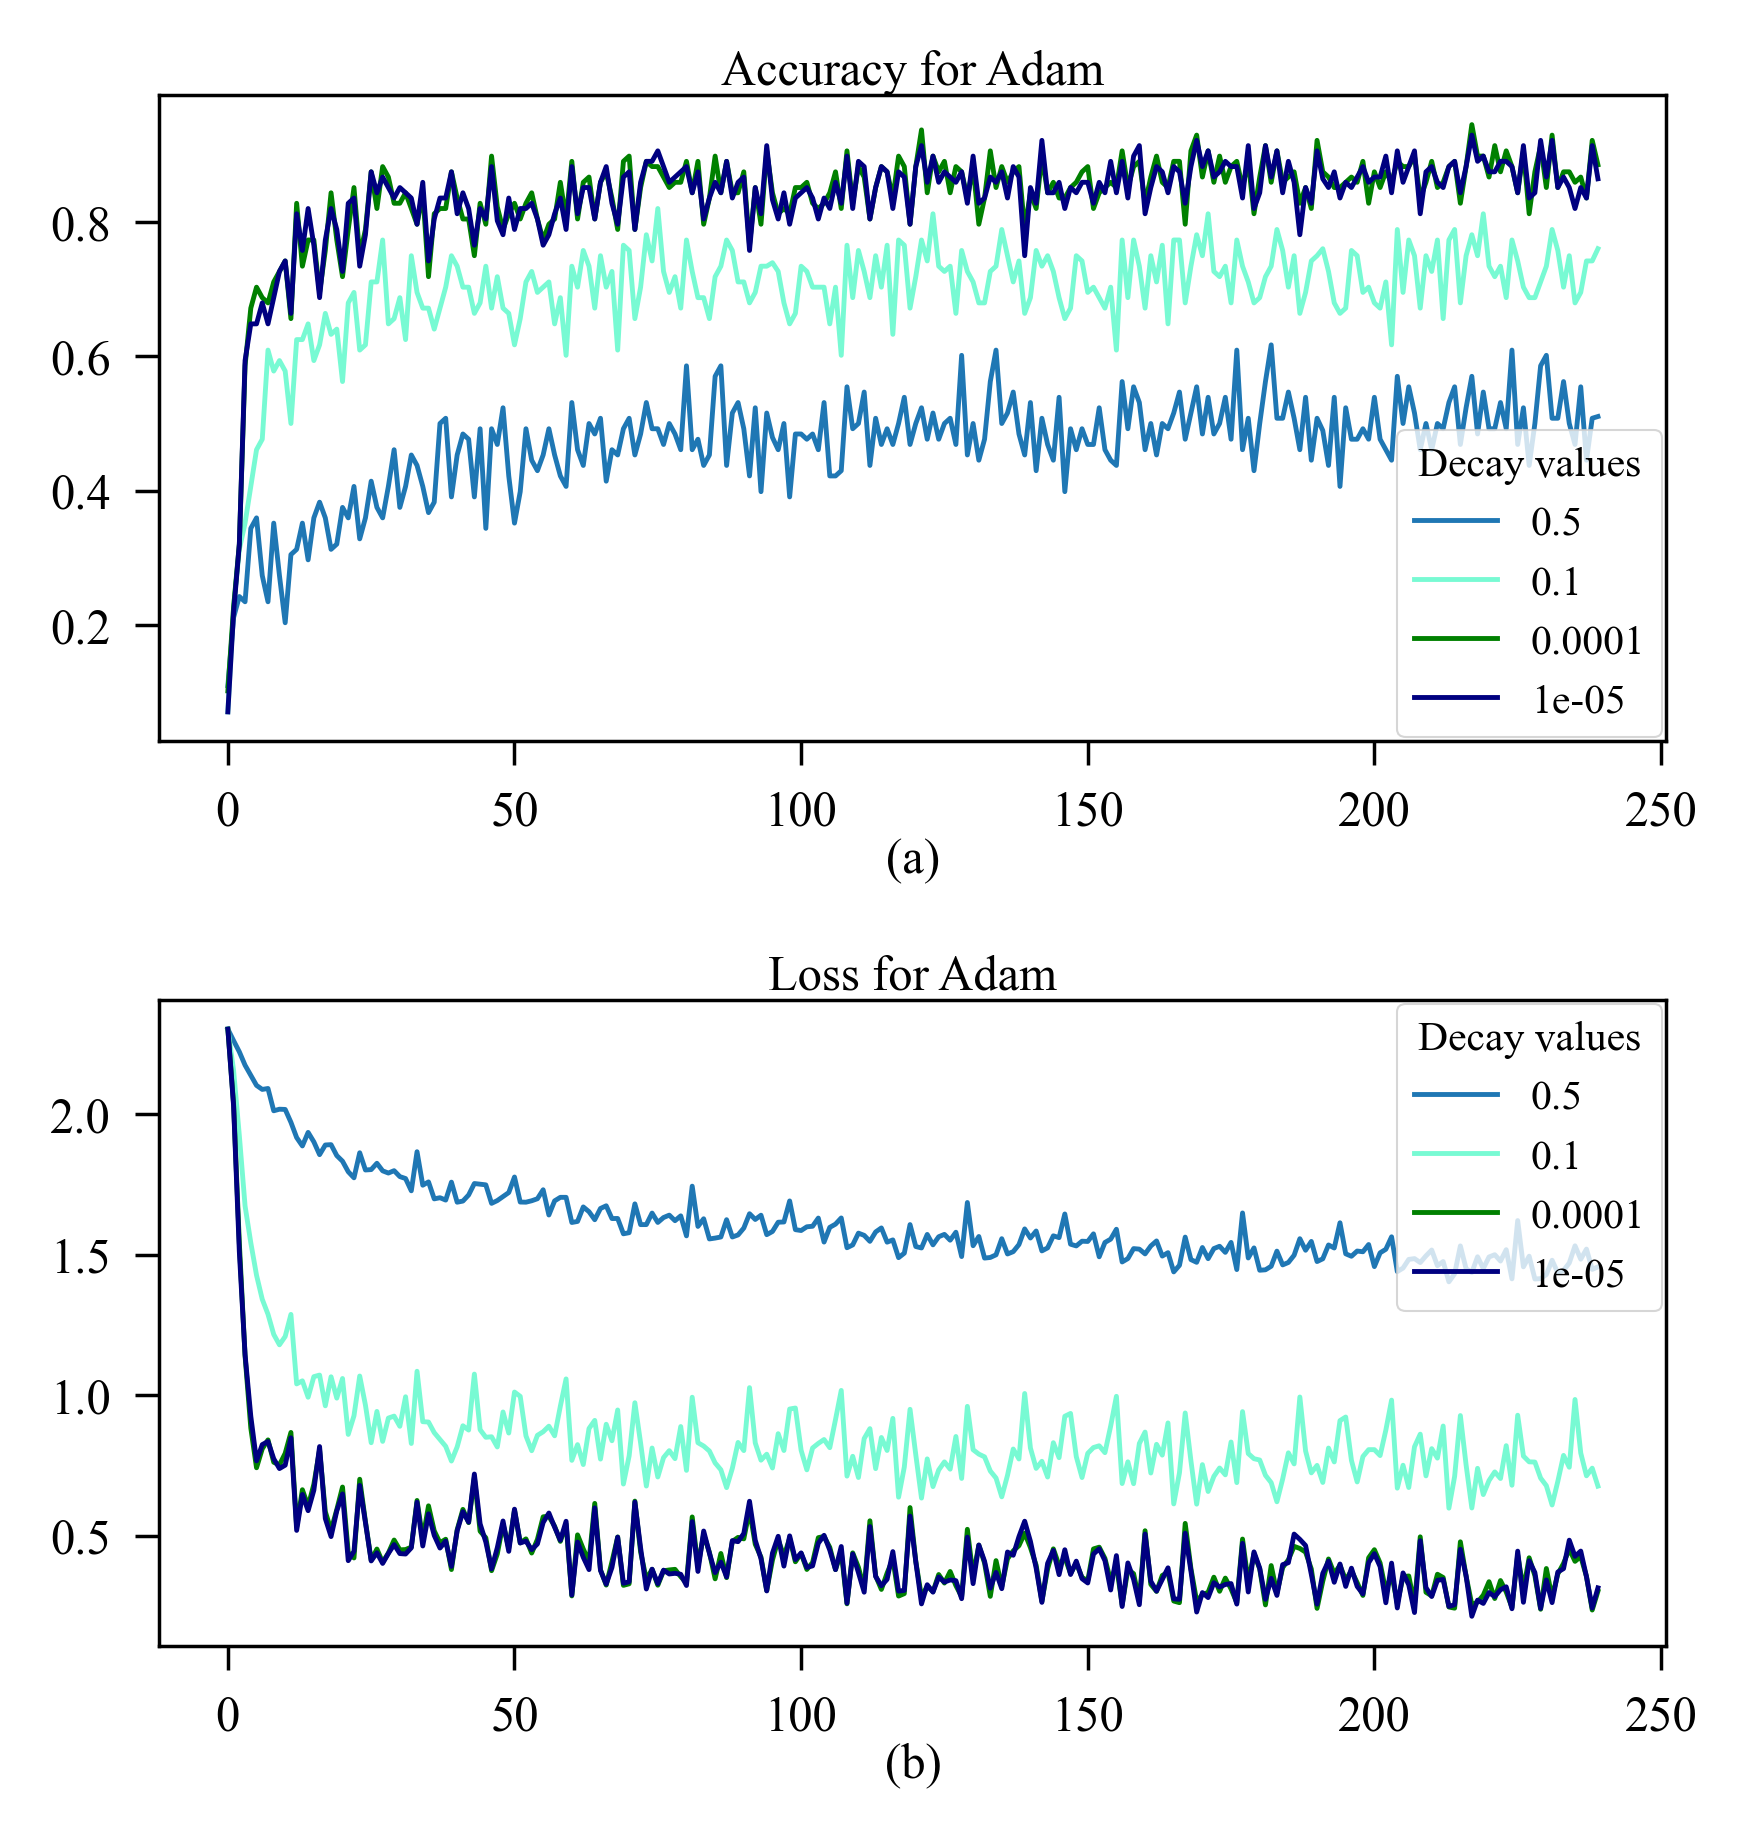

In [223]:
fig, ax = plt.subplots(2,1,figsize = (88*mm , 88*mm),
                           gridspec_kw = {'wspace':0.5,'hspace':0.4},dpi=500)
fig.subplots_adjust(left=.1, bottom=.08, right=0.97, top=0.975)
ax[0].plot(acc_ada[0],label=f'{decay_list[0]}',lw=0.7)
ax[0].plot(acc_ada[1],'#78FAD3',label=f'{decay_list[1]}',lw=0.7,)
ax[0].plot(acc_ada[2],'g',label=f'{decay_list[2]}',lw=0.7,)
ax[0].plot(acc_ada[3],'navy',label=f'{decay_list[3]}',lw=0.7,)
ax[0].set_title('Accuracy for Adam',fontsize=7,pad=-0.25)
ax[0].legend(fontsize=6, title='Decay values',title_fontsize=6,ncol=1,loc='lower right',borderaxespad=0.1).get_frame().set_linewidth(0.3)
ax[0].set_xlabel('(a)',fontsize=7,labelpad=0.25)


ax[0].tick_params(axis='both', which='major',width=0.5, labelsize=7)
for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(0.5)


ax[1].plot(loss_ada[0],lw=0.7,label=f'{decay_list[0]}')
ax[1].plot(loss_ada[1],'#78FAD3',lw=0.7,label=f'{decay_list[1]}')
ax[1].plot(loss_ada[2],'g',lw=0.7,label=f'{decay_list[2]}')
ax[1].plot(loss_ada[3],'navy',lw=0.7,label=f'{decay_list[3]}')
ax[1].set_title('Loss for Adam',fontsize=7,pad=-0.25)
ax[1].set_xlabel('(b)',fontsize=7,labelpad=0.25)
ax[1].tick_params(axis='both', which='major',width=0.5, labelsize=7)
ax[1].legend(fontsize=6, title='Decay values',title_fontsize=6,ncol=1,loc='upper right',borderaxespad=0.1).get_frame().set_linewidth(0.3)
for axis in ['top','bottom','left','right']:
    ax[1].spines[axis].set_linewidth(0.5)
    
fig.savefig(my_path+'/Adam.pdf',dpi=400)

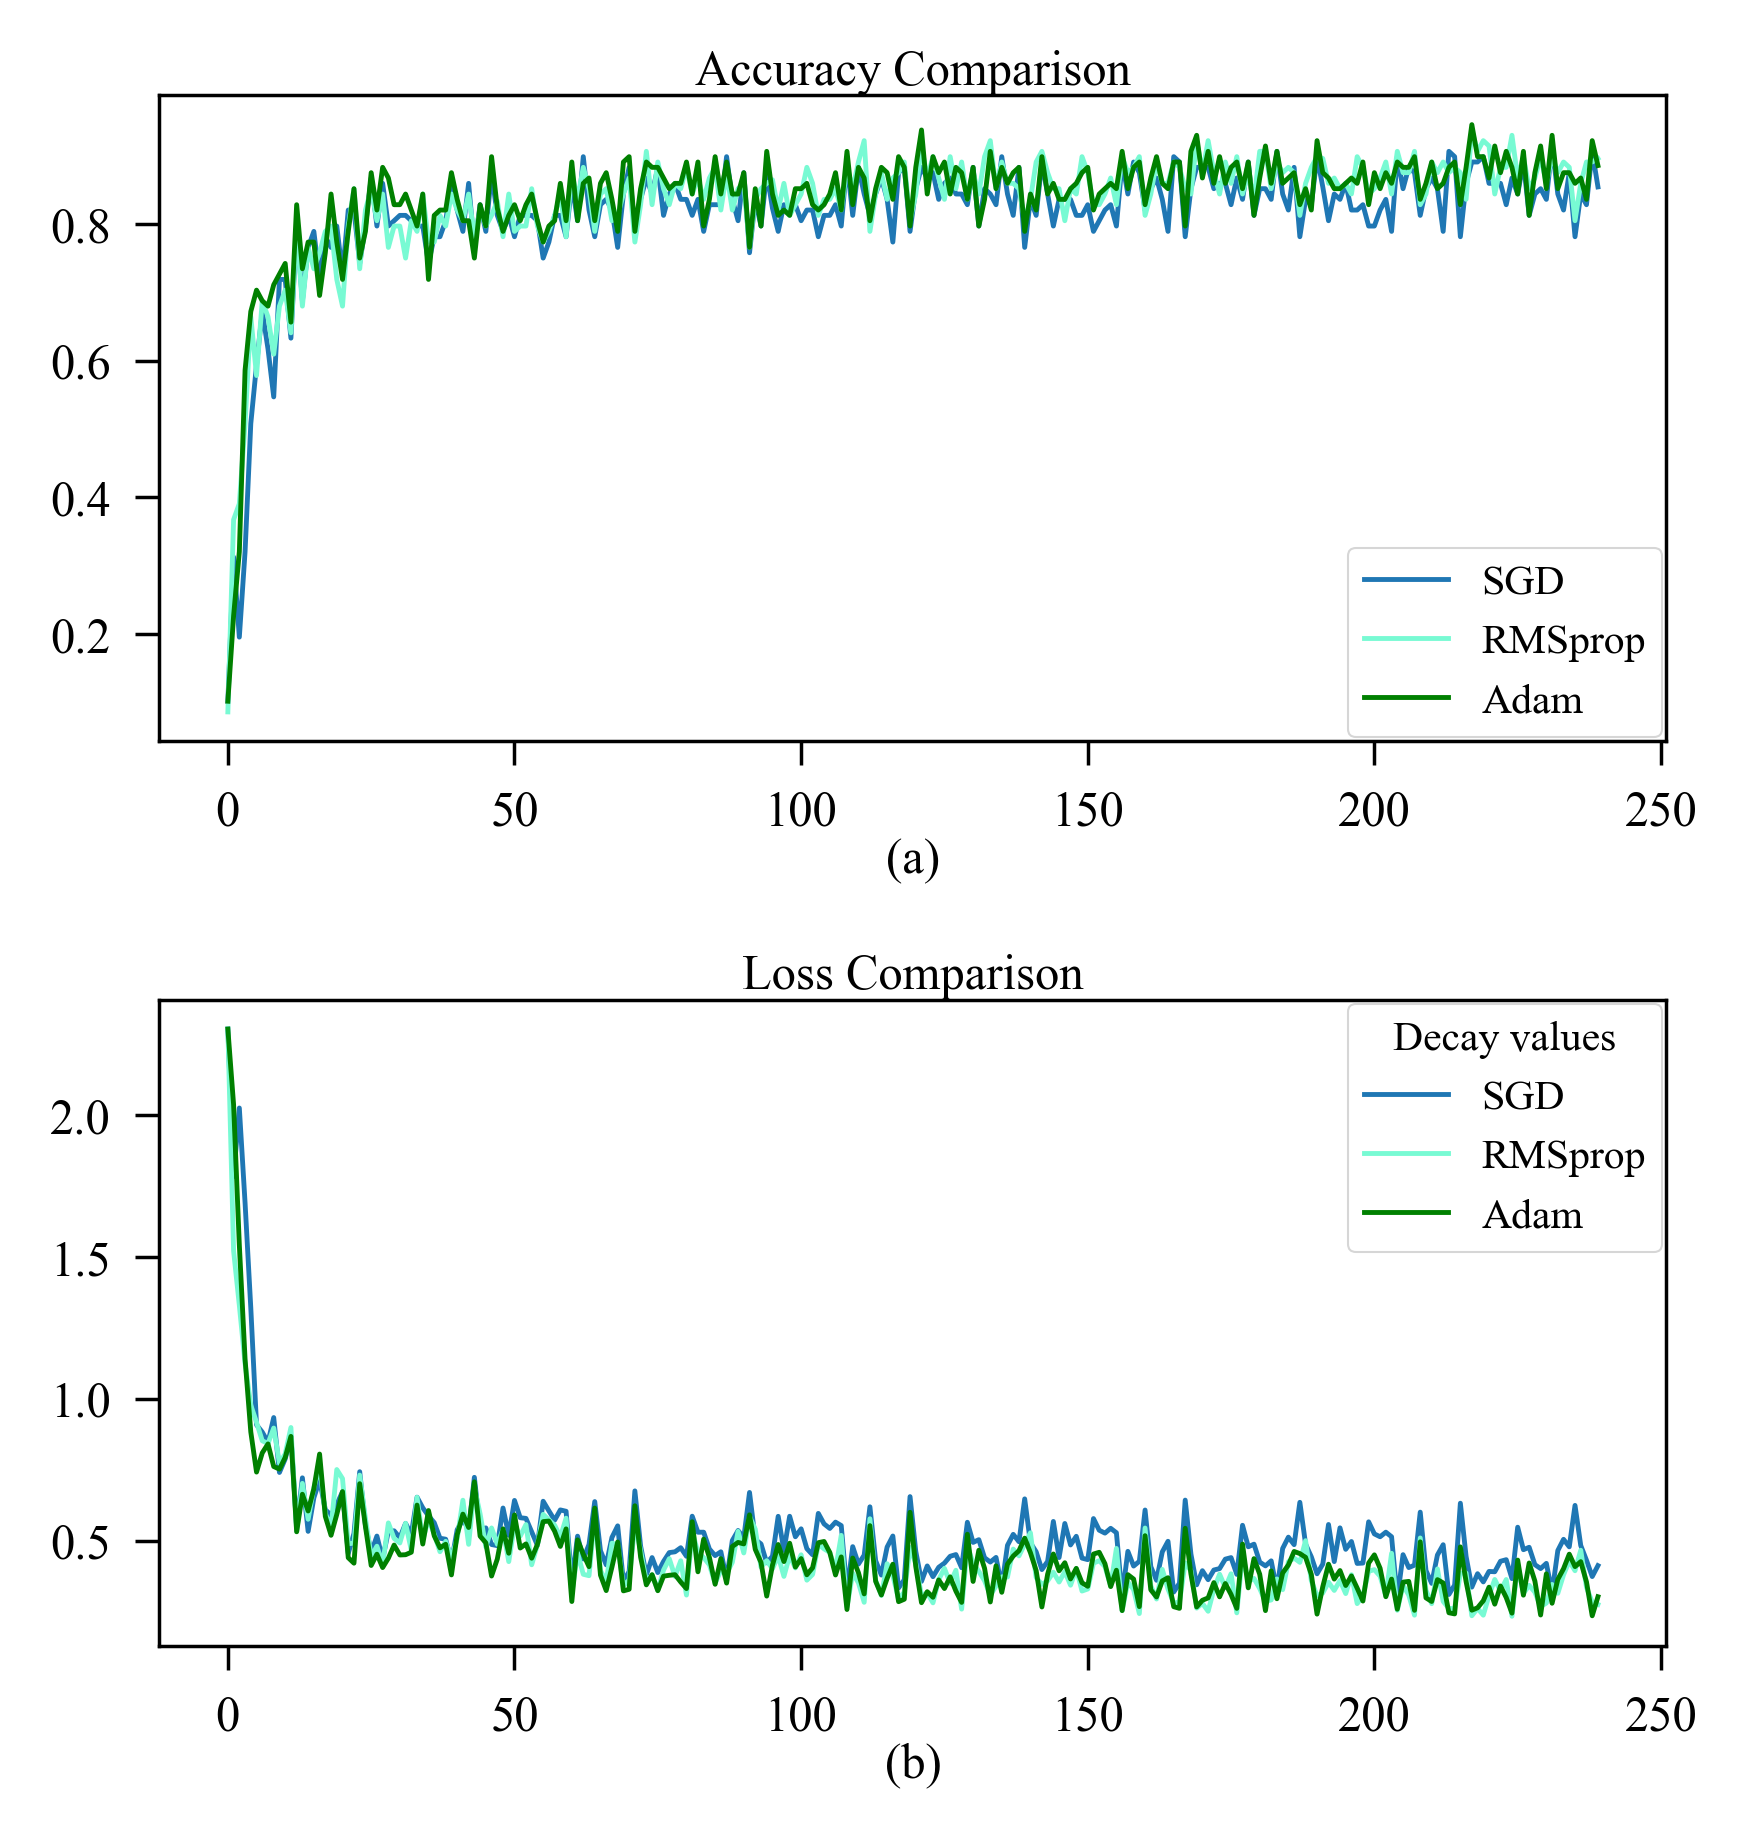

In [224]:
fig, ax = plt.subplots(2,1,figsize = (88*mm , 88*mm),
                           gridspec_kw = {'wspace':0.5,'hspace':0.4},dpi=500)
fig.subplots_adjust(left=.1, bottom=.08, right=0.97, top=0.975)
ax[0].plot(acc_sgd[1],label=f'SGD',lw=0.7)
ax[0].plot(acc_rms[2],'#78FAD3',label=f'RMSprop',lw=0.7,)
ax[0].plot(acc_ada[2],'g',label=f'Adam',lw=0.7,)
#ax[0].plot(acc_ada[3],'navy',label=f'{decay_list[3]}',lw=0.7,)
ax[0].set_title('Accuracy Comparison',fontsize=7,pad=-0.25)
ax[0].legend(fontsize=6,title_fontsize=6,ncol=1,loc='lower right',borderaxespad=0.1).get_frame().set_linewidth(0.3)
ax[0].set_xlabel('(a)',fontsize=7,labelpad=0.25)


ax[0].tick_params(axis='both', which='major',width=0.5, labelsize=7)
for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(0.5)


ax[1].plot(loss_sgd[1],lw=0.7,label=f'SGD')
ax[1].plot(loss_rms[2],'#78FAD3',lw=0.7,label=f'RMSprop')
ax[1].plot(loss_ada[2],'g',lw=0.7,label=f'Adam')
#ax[1].plot(loss_ada[3],'navy',lw=0.7,label=f'{decay_list[3]}')
ax[1].set_title('Loss Comparison',fontsize=7,pad=-0.25)
ax[1].set_xlabel('(b)',fontsize=7,labelpad=0.25)
ax[1].tick_params(axis='both', which='major',width=0.5, labelsize=7)
ax[1].legend(fontsize=6, title='Decay values',title_fontsize=6,ncol=1,loc='upper right',borderaxespad=0.1).get_frame().set_linewidth(0.3)
for axis in ['top','bottom','left','right']:
    ax[1].spines[axis].set_linewidth(0.5)
    
fig.savefig(my_path+'/comparison.pdf',dpi=400)

In [108]:
new_array=np.empty((2,3))
new_array[0]=np.array([[1,2,3]])
new_array

array([[1.        , 2.        , 3.        ],
       [1.92958295, 2.08543253, 1.70046973]])

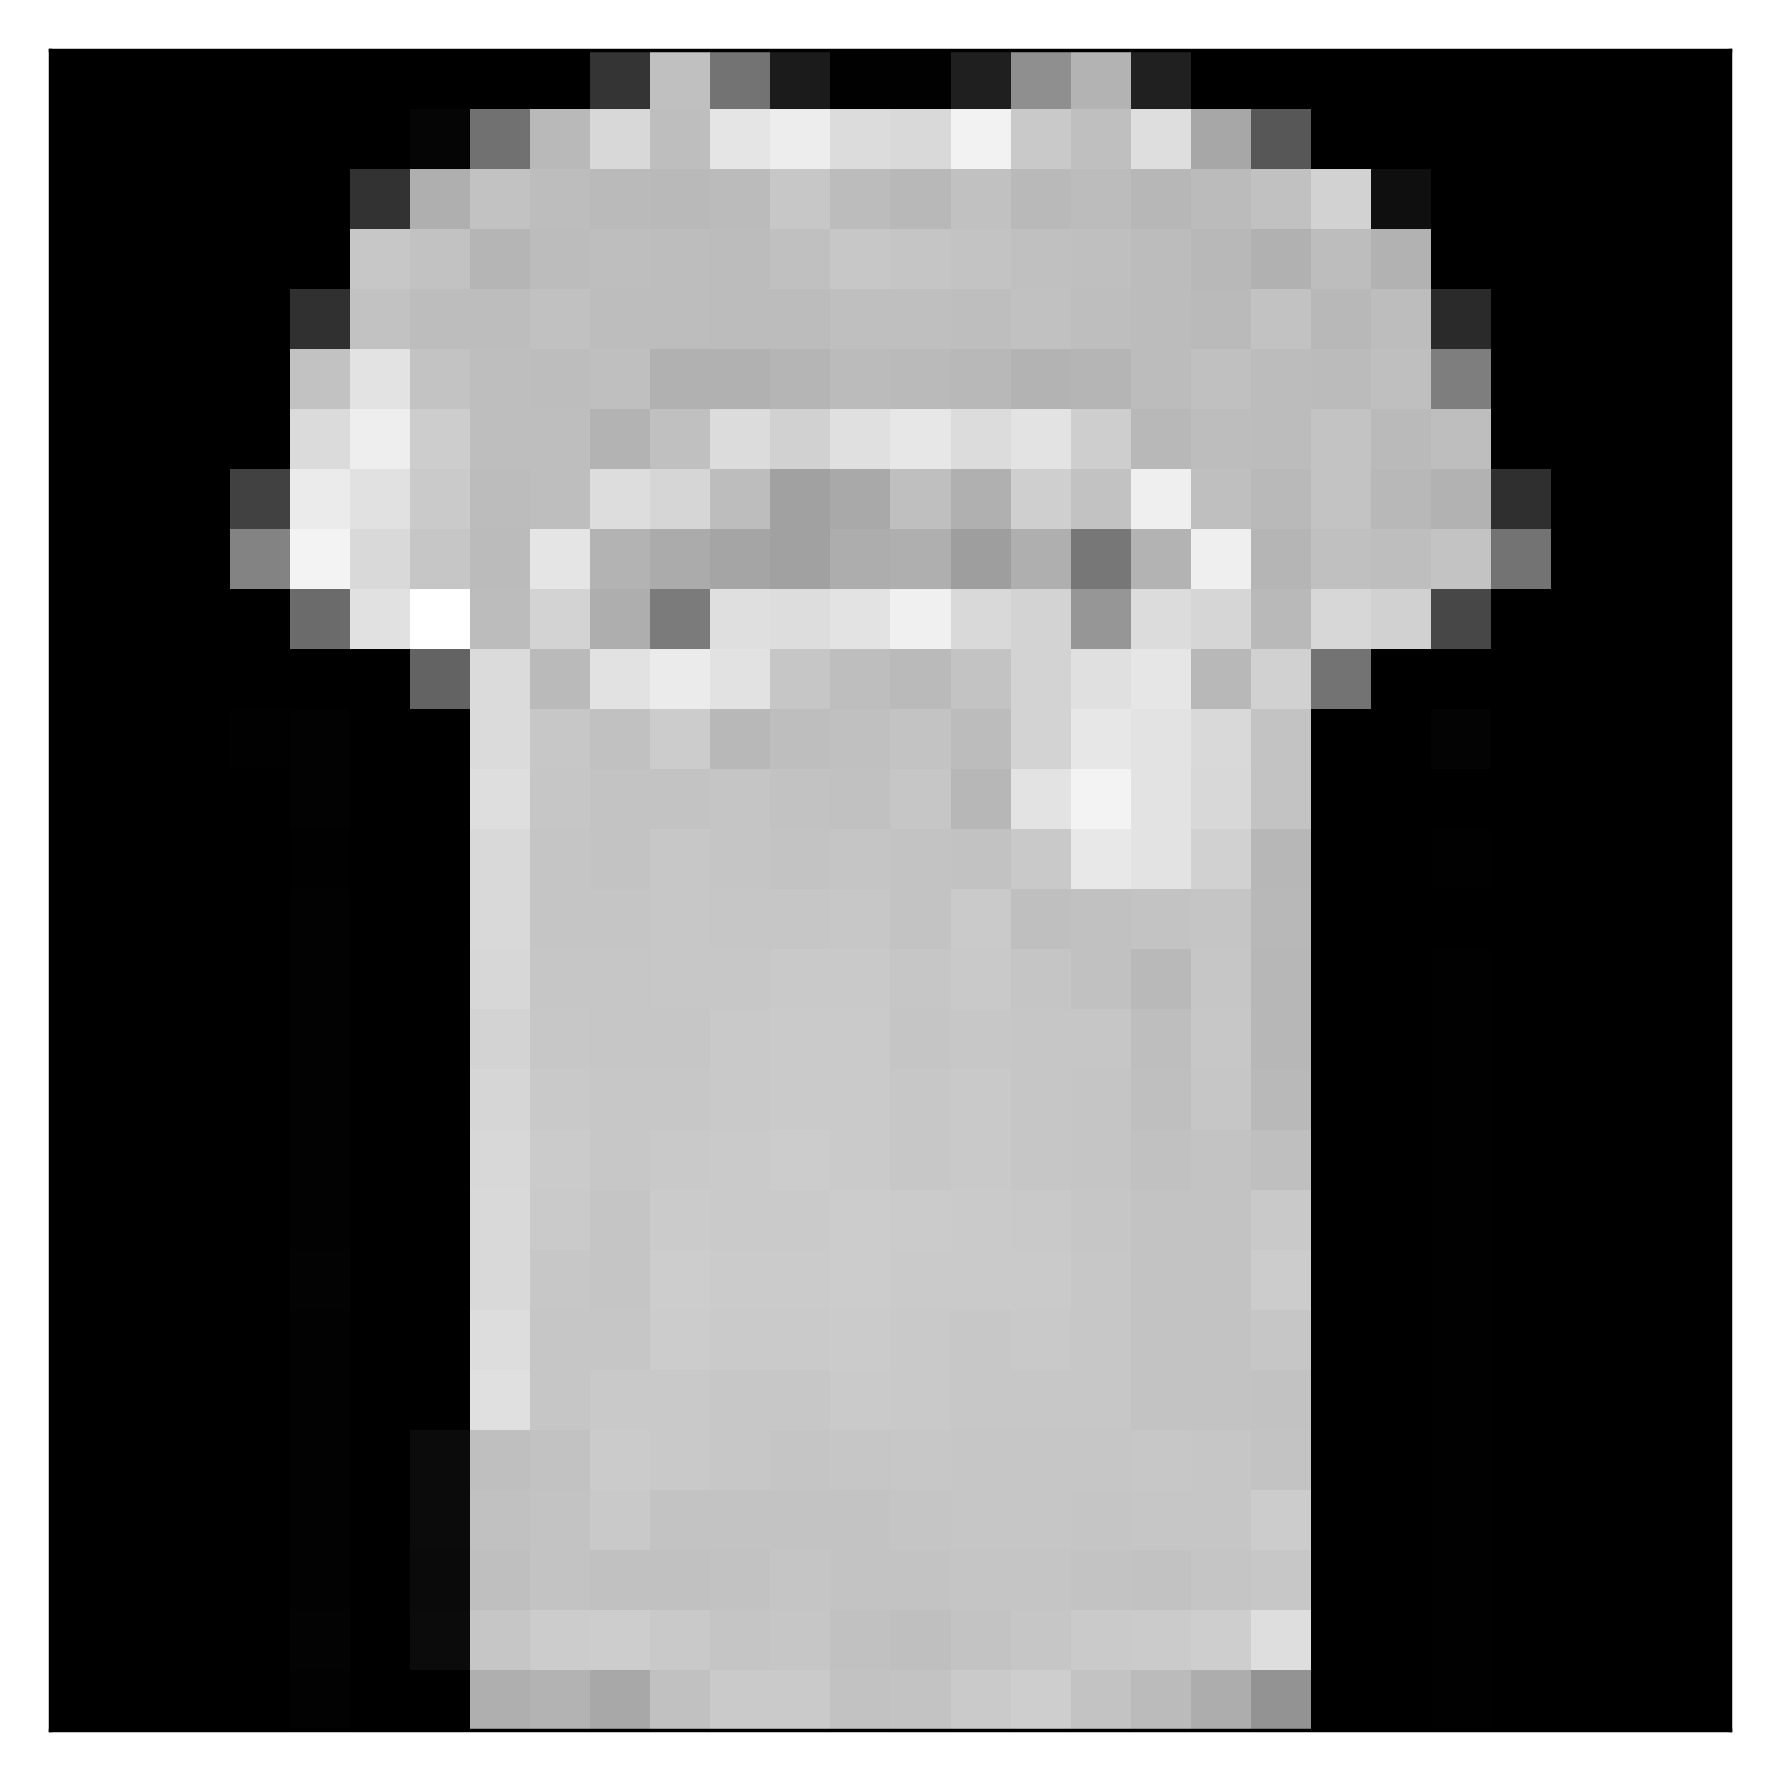

In [212]:
fig, ax = plt.subplots(1,1,figsize = (88*mm , 88*mm),
                           gridspec_kw = {'wspace':0.05,'hspace':0.05},dpi=500)
fig.subplots_adjust(left=.01, bottom=.01, right=0.98, top=0.98)
test = X_test[0].reshape(28,28)*127.5+127.5
ax.imshow(test,cmap='gray')
ax.tick_params(axis='both', which='major',bottom=False, labelbottom=False,left=False,labelleft=False)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
fig.savefig(my_path+'/data.pdf',dpi=400)